# Algoritimo Genético

# 1. Introdução

Olá! Meu nome é joão luiz, integrante do Grupo 30 da pos graduação IA para Devs 2025.

Na Fase 2 Apresento esse projeto de Algoritimo Genético focado em distribuir alunos em turmas, buscando o equilíbrio de atributos como:

Primeira letra do nome (PrimeiraLetra)
Procedência (Procedencia)
Sexo (Sexo)
Idade (Idade)


```
Edher                - RM361040
Yago Marialva        - RM361884
João Sá              - RM363107
Franclin             - RM364871
Pavão                - RM364496
```

## Importação biblioteca

In [3]:
import numpy as np
import pandas as pd
import pygad
from prettytable import PrettyTable

from itertools import repeat, chain
from collections import defaultdict, Counter
import random

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white", palette=None)

from ga import obtenha_alunos
from ga import calcula_penalidade


## Preparação dos dados


Leitura de arquivo de informações iniciais que se pode encontrar:

In [4]:
df = pd.read_csv('alunos.csv')

maximo_alunos_por_turma = 25 #Esse é a proporção ideal para que uma turma não fique completamente cheia e que permita depois novos alunos poderão ser enturmados
total_alunos = df.Nome.count()
numero_turmas = int(np.ceil(total_alunos / maximo_alunos_por_turma))
total_alunos_por_turma_distribuida = int(np.ceil(total_alunos / numero_turmas))
ocupacao_maxima = int(numero_turmas * maximo_alunos_por_turma) #Esse é o número máximo de alunos se todas as turmas estivessem preenchidas com o máximo permitido
ocupacao_total_turmas = total_alunos_por_turma_distribuida * numero_turmas

print(f"Total de alunos: {total_alunos}")
print(f"Quantidade de turmas: {numero_turmas}")
print(f"Quantidade de alunos por turma: {total_alunos_por_turma_distribuida}") 
print(f"Ocupação turmas: {ocupacao_total_turmas}") 
print(f"Ocupação máxima total: {ocupacao_maxima}")

Total de alunos: 119
Quantidade de turmas: 5
Quantidade de alunos por turma: 24
Ocupação turmas: 120
Ocupação máxima total: 125


### Uma análise para cada restrição

Organizando alunos pela primeira letra do nome, e calculando quantas turmas precisam ter alunos com essa letra.

In [5]:
df_agrupado_primeira_letra = df.groupby('PrimeiraLetra')['PrimeiraLetra'].agg([
    ('Contagem', 'count'),
    ('MinimoTurma', lambda x: np.floor(x.count() / numero_turmas)),
    ('MaximoTurma', lambda x: np.ceil(x.count() / numero_turmas)),
]).reset_index()
df_agrupado_primeira_letra

,PrimeiraLetra,Contagem,MinimoTurma,MaximoTurma
0,A,10,2.0,2.0
1,B,4,0.0,1.0
2,C,7,1.0,2.0
3,D,8,1.0,2.0
4,E,5,1.0,1.0
5,F,5,1.0,1.0
6,G,8,1.0,2.0
7,H,11,2.0,3.0
8,I,4,0.0,1.0
9,J,10,2.0,2.0


Organizando alunos pela procedencia, ou seja, pela origem dos alunos (por exemplo: escola anterior, cidade, etc.).

In [6]:
df_agrupado_procedencia = df.groupby('Procedencia')['Procedencia'].agg([
    ('Contagem', 'count'),
    ('MinimoTurma', lambda x: np.floor(x.count() / numero_turmas)),
    ('MaximoTurma', lambda x: np.ceil(x.count() / numero_turmas)),
]).reset_index()
df_agrupado_procedencia

,Procedencia,Contagem,MinimoTurma,MaximoTurma
0,1,2,0.0,1.0
1,132,2,0.0,1.0
2,254,8,1.0,2.0
3,289,5,1.0,1.0
4,368,74,14.0,15.0
5,380,1,0.0,1.0
6,385,2,0.0,1.0
7,31577,2,0.0,1.0
8,32342,1,0.0,1.0
9,501263,1,0.0,1.0


Agrupamento por sexo dos alunos, com o mesmo objetivo: calcular os limites mínimo e máximo por turma, garantindo uma distribuição equilibrada de meninos e meninas.

In [7]:
df_agrupado_sexo = df.groupby('Sexo')['Sexo'].agg([
    ('Contagem', 'count'),
    ('MinimoTurma', lambda x: np.floor(x.count() / numero_turmas)),
    ('MaximoTurma', lambda x: np.ceil(x.count() / numero_turmas)),
]).reset_index()
df_agrupado_sexo

,Sexo,Contagem,MinimoTurma,MaximoTurma
0,F,43,8.0,9.0
1,M,76,15.0,16.0


Agrupa alunos por faixa etária (Idade) e calcula quantos devem ser alocados em cada turma, garantindo que alunos de uma mesma idade fiquem bem distribuídos.

In [8]:
df_agrupado_idade = df.groupby('Idade')['Idade'].agg([
    ('Contagem', 'count'),
    ('MinimoTurma', lambda x: np.floor(x.count() / numero_turmas)),
    ('MaximoTurma', lambda x: np.ceil(x.count() / numero_turmas)),
])
df_agrupado_idade

,Contagem,MinimoTurma,MaximoTurma
Idade,,,
9,1,0.0,1.0
10,2,0.0,1.0
11,84,16.0,17.0
12,32,6.0,7.0


## Calculando os pisos e tetos para montar as penalidades com base nos mínimos e máximos de cada restrição

Prepara os limites de diversidade que serão usados pelo algoritmo genético. Ele transforma os dados agrupados em dicionários de referência, para orientar como os alunos devem ser distribuídos por turma.

In [9]:
grupo_sexo = df.groupby('Sexo')['Sexo'].value_counts().to_dict()
grupo_pl = df.groupby('PrimeiraLetra')['PrimeiraLetra'].value_counts().to_dict()
grupo_procedencia = df.groupby('Procedencia')['Procedencia'].value_counts().to_dict()
grupo_idade = df.groupby('Idade')['Idade'].value_counts().to_dict()

grupo_sexo_pt = {k: [int(np.floor(v / numero_turmas)), int(np.ceil(v / numero_turmas))] for k, v in grupo_sexo.items()}
grupo_pl_pt = {k: [int(np.floor(v / numero_turmas)), int(np.ceil(v / numero_turmas))] for k, v in grupo_pl.items()}
grupo_procedencia_pt = {k: [int(np.floor(v / numero_turmas)), int(np.ceil(v / numero_turmas))] for k, v in grupo_procedencia.items()}
grupo_idade_pt = {k: [int(np.floor(v / numero_turmas)), int(np.ceil(v / numero_turmas))] for k, v in grupo_idade.items()}

print(f"Sexo: {grupo_sexo}")
print(f"Idade: {grupo_idade}")
print(f"Procedencia: {grupo_procedencia}")
print(f"Primeira letra: {grupo_pl}\n")

print(grupo_sexo_pt)
print(grupo_pl_pt)
print(grupo_procedencia_pt)
print(grupo_idade_pt)

Sexo: {'F': 43, 'M': 76}
Idade: {9: 1, 10: 2, 11: 84, 12: 32}
Procedencia: {1: 2, 132: 2, 254: 8, 289: 5, 368: 74, 380: 1, 385: 2, 31577: 2, 32342: 1, 501263: 1, 501334: 4, 501421: 1, 501446: 14, 501503: 1, 501592: 1}
Primeira letra: {'A': 10, 'B': 4, 'C': 7, 'D': 8, 'E': 5, 'F': 5, 'G': 8, 'H': 11, 'I': 4, 'J': 10, 'K': 1, 'L': 15, 'M': 17, 'O': 1, 'P': 5, 'R': 1, 'T': 3, 'V': 3, 'Y': 1}

{'F': [8, 9], 'M': [15, 16]}
{'A': [2, 2], 'B': [0, 1], 'C': [1, 2], 'D': [1, 2], 'E': [1, 1], 'F': [1, 1], 'G': [1, 2], 'H': [2, 3], 'I': [0, 1], 'J': [2, 2], 'K': [0, 1], 'L': [3, 3], 'M': [3, 4], 'O': [0, 1], 'P': [1, 1], 'R': [0, 1], 'T': [0, 1], 'V': [0, 1], 'Y': [0, 1]}
{1: [0, 1], 132: [0, 1], 254: [1, 2], 289: [1, 1], 368: [14, 15], 380: [0, 1], 385: [0, 1], 31577: [0, 1], 32342: [0, 1], 501263: [0, 1], 501334: [0, 1], 501421: [0, 1], 501446: [2, 3], 501503: [0, 1], 501592: [0, 1]}
{9: [0, 1], 10: [0, 1], 11: [16, 17], 12: [6, 7]}


## População inicial

Preparação da lista final de alunos que será usada pelo algoritmo genético para formar as turmas.

In [10]:
alunos_tuplas = list(df.itertuples(index=False,name='Aluno'))

# Completa a lista com None, representando cadeiras vazias nas turmas
lista_completa_alunos = list(chain(
    alunos_tuplas,
    repeat(None, ocupacao_total_turmas - len(alunos_tuplas))
))

Criação da população inicial para o algoritmo genético — ou seja, os primeiros candidatos à solução de enturmação.

In [11]:
individuo1 = list(range(0, ocupacao_total_turmas))
individuo2 = list(range(0, ocupacao_total_turmas))
individuo3 = list(range(0, ocupacao_total_turmas))
individuo4 = list(range(0, ocupacao_total_turmas))
random.shuffle(individuo1)
random.shuffle(individuo2)
random.shuffle(individuo3)
random.shuffle(individuo4)

print(individuo1)
print(individuo2)
print(individuo3)
print(individuo4)

initial_population = [individuo1, individuo2, individuo3, individuo4]

[88, 112, 68, 86, 4, 77, 115, 74, 9, 7, 59, 70, 89, 85, 79, 80, 78, 18, 49, 87, 72, 21, 22, 61, 1, 103, 44, 54, 25, 52, 63, 111, 83, 5, 20, 104, 36, 40, 37, 45, 26, 41, 73, 109, 42, 11, 60, 43, 34, 46, 32, 106, 16, 58, 29, 117, 102, 27, 95, 105, 116, 38, 2, 107, 50, 84, 56, 35, 91, 6, 71, 99, 53, 75, 93, 69, 81, 12, 118, 15, 33, 82, 98, 92, 48, 119, 3, 76, 24, 108, 39, 94, 28, 19, 8, 62, 17, 47, 14, 31, 66, 23, 114, 97, 57, 67, 55, 64, 113, 10, 100, 101, 13, 65, 30, 96, 0, 110, 51, 90]
[110, 60, 68, 6, 65, 112, 71, 37, 12, 58, 47, 89, 49, 56, 2, 13, 82, 46, 102, 38, 86, 15, 57, 80, 39, 64, 63, 118, 107, 52, 30, 83, 7, 95, 84, 114, 59, 51, 116, 25, 48, 5, 91, 32, 98, 113, 1, 97, 19, 50, 41, 36, 43, 9, 44, 23, 72, 28, 22, 81, 100, 3, 54, 88, 92, 70, 67, 31, 55, 4, 119, 17, 45, 87, 115, 76, 14, 10, 90, 108, 73, 42, 94, 66, 77, 29, 0, 35, 69, 101, 61, 75, 103, 99, 104, 62, 53, 21, 26, 105, 96, 8, 79, 18, 16, 109, 78, 24, 33, 106, 20, 111, 93, 40, 117, 27, 34, 74, 85, 11]
[42, 61, 118, 110,

Definindo a função de avaliação (fitness) do algoritmo genético — a parte mais crítica!
Ela mede quão boa é cada solução, com base no quanto ela respeita os limites de diversidade definidos anteriormente.

In [12]:
def calcula_penalidades(alunos_turma, sexo_pt, pl_pt, procedencia_pt, idade_pt):
    qtd_sexo = Counter([aluno.Sexo for aluno in alunos_turma])
    qtd_letras = Counter([aluno.PrimeiraLetra for aluno in alunos_turma])
    qtd_procedencia = Counter([aluno.Procedencia for aluno in alunos_turma])
    qtd_idade = Counter([aluno.Idade for aluno in alunos_turma])        
    return [calcula_penalidade(qtd_sexo, sexo_pt), calcula_penalidade(qtd_letras, pl_pt), calcula_penalidade(qtd_procedencia, procedencia_pt), calcula_penalidade(qtd_idade, idade_pt)]

def fitness_func(ga_instance, solution, solution_idx):
    turmas_solution = np.reshape(solution, newshape=(numero_turmas, total_alunos_por_turma_distribuida))
    penalidades_total = 0
    for turma in turmas_solution:
        alunos_turma = obtenha_alunos(lista_completa_alunos, turma)
        penalidades = np.sum(calcula_penalidades(alunos_turma, grupo_sexo_pt, grupo_pl_pt, grupo_procedencia_pt, grupo_idade_pt))
        penalidades_total += penalidades
    return 1 / penalidades_total

Configuração dos parâmetros do algoritmo genético pygad, controlando como as soluções evoluem ao longo das gerações.

In [13]:
num_generations = 150000
num_parents_mating = 2

sol_per_pop = 2
num_genes = ocupacao_total_turmas
init_range_low = 0
init_range_high = ocupacao_total_turmas
gene_space = [i for i in range(0, ocupacao_total_turmas)]

parent_selection_type = "rank"
keep_parents = 2 
crossover_type = "single_point" 

mutation_type = "swap" 
mutation_percent_genes = 20


Executa o algoritmo genético com a biblioteca pygad e exibe a evolução da qualidade das soluções ao longo das gerações.

c:\Users\JuninhoDRZ\AppData\Local\Programs\Python\Python39\lib\site-packages\pygad\visualize\plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


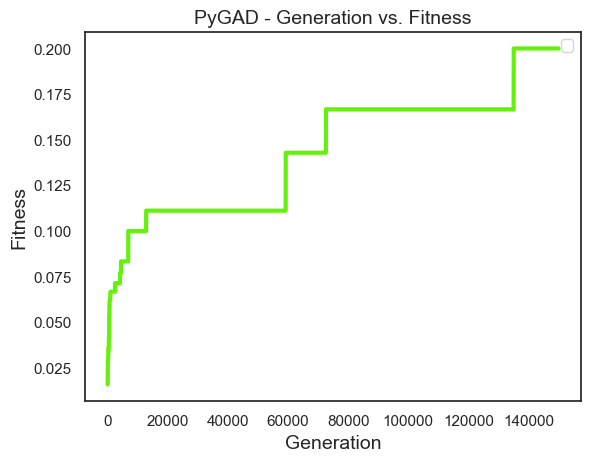

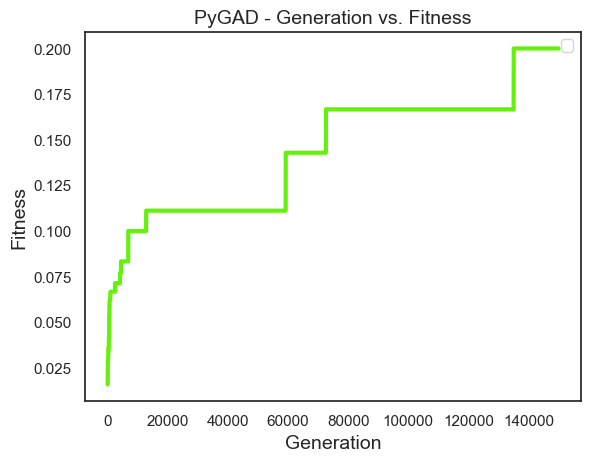

In [14]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       initial_population=initial_population,
                       gene_space = gene_space,
                       fitness_func=fitness_func,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False,
                       gene_type=int)

ga_instance.run()

ga_instance.plot_fitness()

✅ Interpretação do gráfico: PyGAD - Generation vs. Fitness
Eixo X (Generation): número da geração (de 0 até 150.000).
Eixo Y (Fitness): inverso da penalidade total. Quanto maior o valor, melhor a solução.

Curva crescente: significa que o algoritmo está melhorando a distribuição dos alunos nas turmas ao longo do tempo, reduzindo as penalidades.

Plateaus: trechos planos onde o algoritmo parou de melhorar por algumas gerações, comum em GAs até encontrar uma nova combinação favorável.

💡 O que o gráfico mostra?

Chegou perto de uma fitness de 0.2, o que indica baixa penalidade (ou seja, turmas balanceadas).
A evolução mostra que foi necessário um grande número de gerações (cerca de 150 mil) para atingir o melhor resultado observado.

 Pega a melhor solução encontrada pelo algoritmo genético e a converte em uma estrutura representando as turmas.

In [15]:
individuo = ga_instance.best_solution()[0]
turmas = np.reshape(individuo, newshape=(numero_turmas, total_alunos_por_turma_distribuida))

Coleta estatísticas por turma com base na distribuição de alunos, após a otimização com algoritmo genético.

In [16]:
lst_sexo = []
lst_letras = []
lst_idade = []
lst_procedencia = []

indice_turma = 1
for turma in turmas:
    alunos_turma = obtenha_alunos(lista_completa_alunos, turma)
    qtd_letras = Counter([aluno.PrimeiraLetra for aluno in alunos_turma])
    qtd_sexo = Counter([aluno.Sexo for aluno in alunos_turma])
    qtd_procedencia = Counter([aluno.Procedencia for aluno in alunos_turma])
    qtd_idade = Counter([aluno.Idade for aluno in alunos_turma])
    for k in qtd_sexo:
        lst_sexo.append({'Turma': indice_turma, 'Sexo': k, 'Quantidade': qtd_sexo[k]})
    for k in qtd_letras:
        lst_letras.append({'Turma': indice_turma, 'Letra': k, 'Quantidade': qtd_letras[k]})
    for k in qtd_idade:
        lst_idade.append({'Turma': indice_turma, 'Idade': k, 'Quantidade': qtd_idade[k]})
    for k in qtd_procedencia:
        lst_procedencia.append({'Turma': indice_turma, 'Procedencia': k, 'Quantidade': qtd_procedencia[k]})

    indice_turma += 1

## Gera um gráfico de barras agrupadas por sexo e turma, utilizando seaborn e matplotlib.

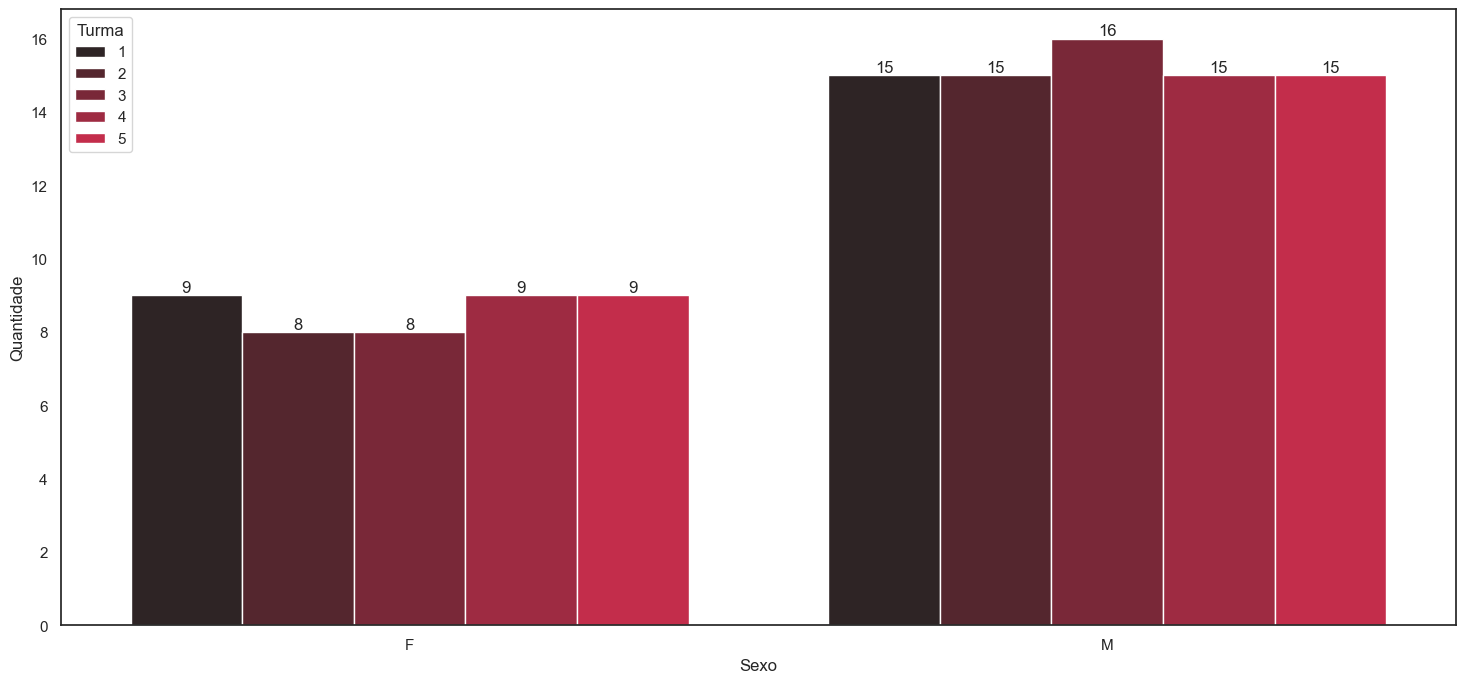

In [17]:
plt.figure(figsize=(18, 8))
df_sexo = pd.DataFrame(data=lst_sexo)
ax = sns.barplot(x = 'Sexo', y = 'Quantidade', hue = 'Turma', data = df_sexo, palette='dark:crimson')
for container in ax.containers:
    ax.bar_label(container)

Todas as turmas têm entre 8 e 9 alunas do sexo feminino.
Todas as turmas têm entre 15 e 16 alunos do sexo masculino.

A distribuição está razoavelmente equilibrada entre as turmas, sugerindo que o algoritmo genético buscou essa homogeneidade.

## Gera um gráfico de barras que mostra a distribuição de alunos por primeira letra do nome, segmentada por turma.

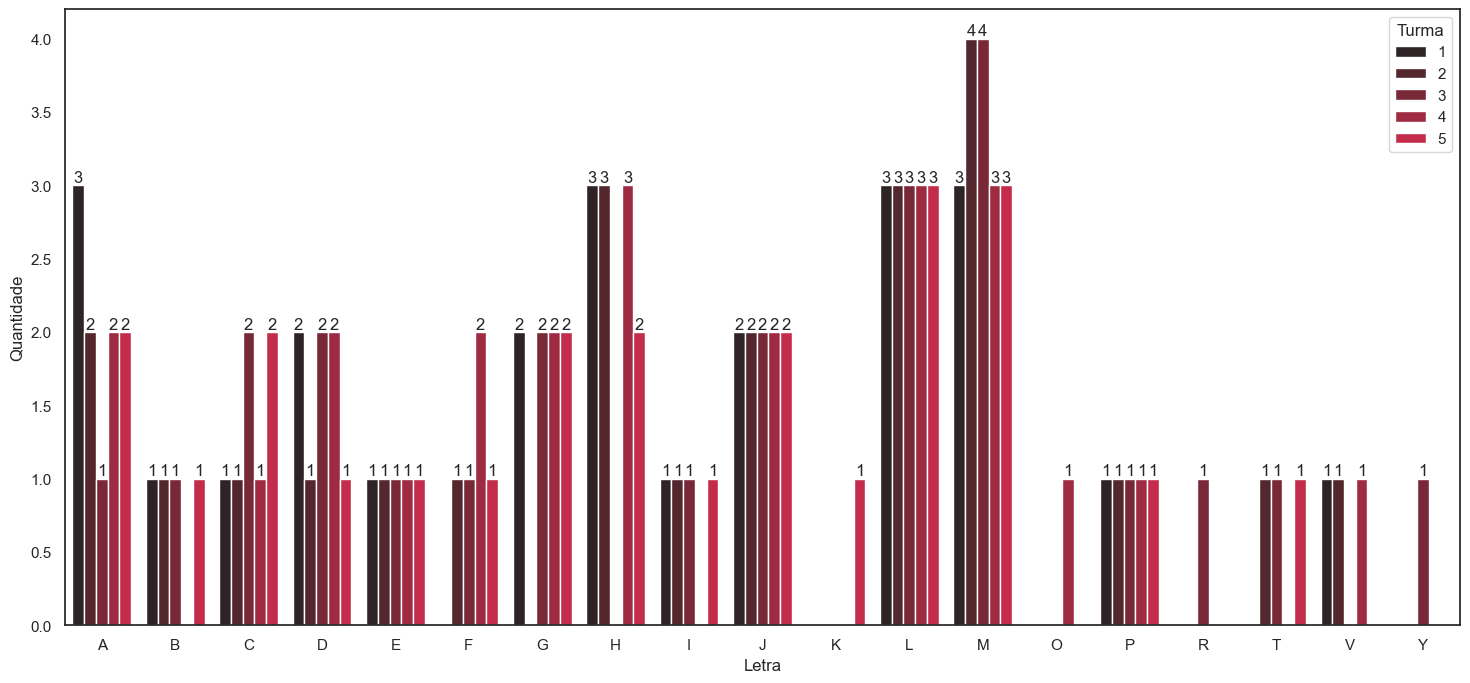

In [18]:
plt.figure(figsize=(18, 8))
df_letras = pd.DataFrame(data=lst_letras)
df_letras.sort_values(by=['Letra'], inplace=True)
ax = sns.barplot(x = 'Letra', y = 'Quantidade', hue = 'Turma', data = df_letras, palette='dark:crimson')
for container in ax.containers:
    ax.bar_label(container)

As turmas estão bem balanceadas em relação às iniciais dos nomes.

Exemplo: A letra "M" tem 4 alunos nas turmas 1 e 2, e 3 nas outras, mostrando distribuição homogênea.

Poucas letras têm concentração em apenas uma turma (ex: letra "O", "R").

## Gera um gráfico que representa a distribuição da idade dos alunos por turma.

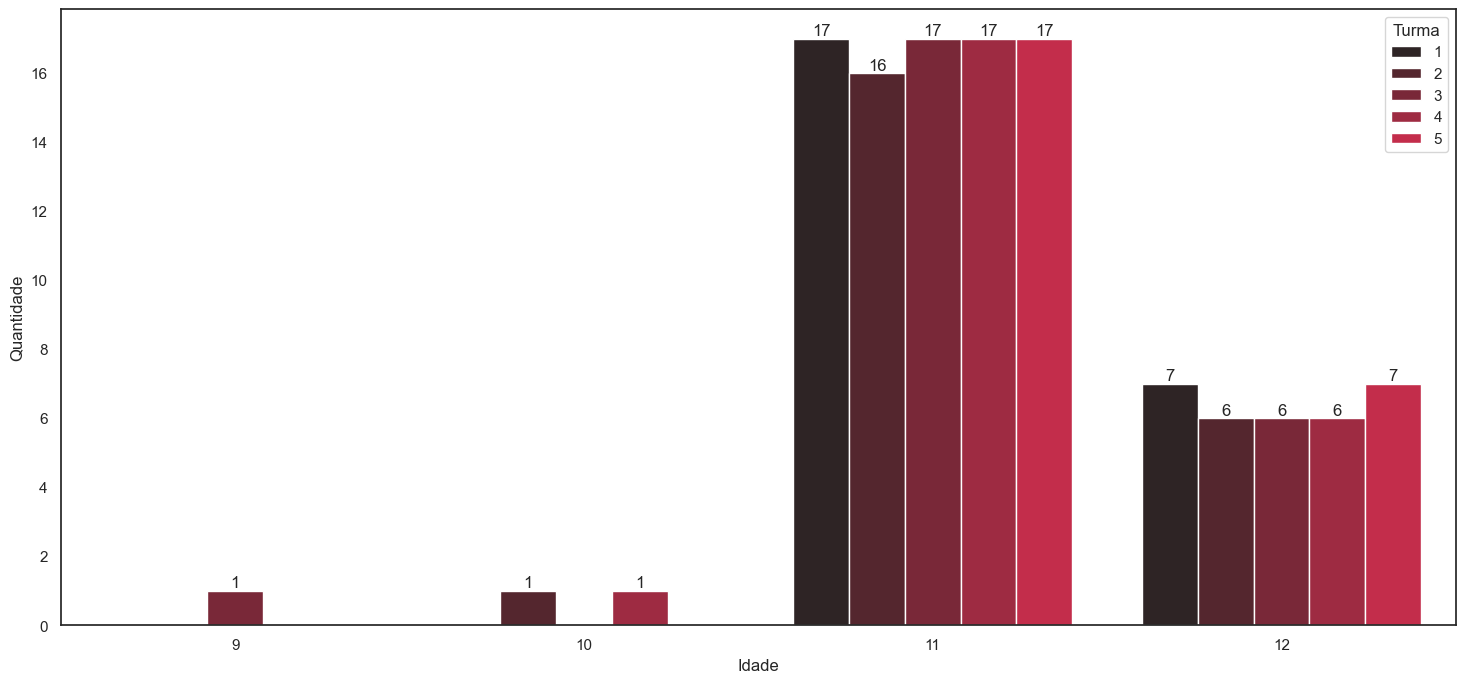

In [19]:
plt.figure(figsize=(18, 8))
df_idade = pd.DataFrame(data=lst_idade)
df_idade.sort_values(by=['Idade'], inplace=True)
ax = sns.barplot(x = 'Idade', y = 'Quantidade', hue = 'Turma', data = df_idade, palette='dark:crimson')
for container in ax.containers:
    ax.bar_label(container)

Idade 11: É claramente a mais frequente, com 16–17 alunos por turma, indicando bom equilíbrio e que a maioria dos alunos tem essa idade.

Idade 12: Está razoavelmente distribuída, com 6–7 alunos por turma.

Idades 9 e 10: Têm ocorrência pontual (apenas 1 aluno por idade em algumas turmas), indicando exceções.

## Gera um gráfico de barras agrupadas que mostra a quantidade de alunos por Procedência em cada Turma.

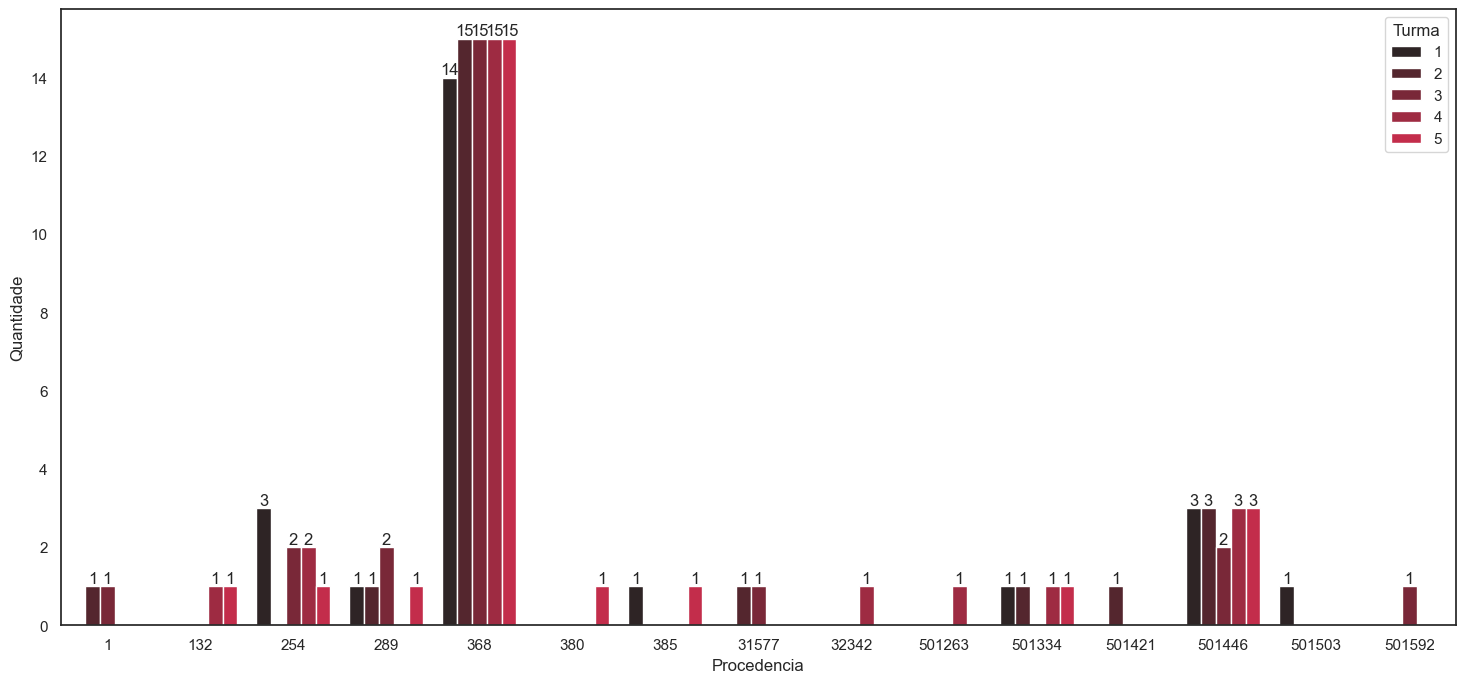

In [20]:
plt.figure(figsize=(18, 8))
df_procedencia = pd.DataFrame(data=lst_procedencia)
df_procedencia.sort_values(by=['Procedencia'], inplace=True)
ax = sns.barplot(x = 'Procedencia', y = 'Quantidade', hue = 'Turma', data = df_procedencia, palette='dark:crimson')
for container in ax.containers:
    ax.bar_label(container)

Procedência 368 domina, com 14 a 15 alunos em cada turma — muito equilibrado.

Outras procedências como 254, 501446, 289 aparecem pontualmente.

Diversidade de procedências foi bem distribuída entre as turmas — um dos objetivos do algoritmo genético.